# Insects Classification using Deep Learning

In [1]:
import os
import shutil
import re
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow and keras to train deep learning model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

# for hyperparams tunning
import kerastuner as kt
import IPython

# import pillow to manipulating img data
import PIL
from PIL import Image

# for explaining nn
import shap

## Transform the image into `np.array`

We can use `pillow` package to load image and convert it to grayscale image (for color image, we will have RGB color values for each pixel, for grayscale image, we only have gray level value for each pixel).

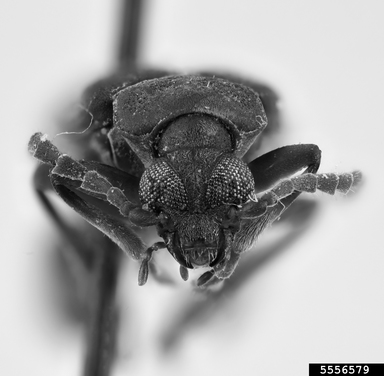

In [2]:
img1 = Image.open("insects/train/beetles/5556579.jpg").convert('L')
img1

In [3]:
img2 = Image.open("insects/train/beetles/5556580.jpg").convert('L')
img1.size, img2.size 

((384, 376), (384, 320))

We can see that images' sizes and shapes are not uniformed, so we should standardized them!

First of all, we transform all the images to square shape, and scale them to 100$\times$100 size.

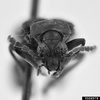

In [4]:
if img1.size != (100,100):
    img1 = img1.crop((0, 0, 376, 376))
    img1.thumbnail((100,100), PIL.Image.ANTIALIAS)
img1

Then we transform the image to `np.array`

In [5]:
np.asarray(img1).shape

(100, 100)

Now, we should do above process for all of the images in train and test folders.

In [6]:
train_path = {
    "beetles" : "insects/train/beetles",
    "cockroach" : "insects/train/cockroach",
    "dragonflies" : "insects/train/dragonflies"
}
train_image_path = []
for insect, path in train_path.items():
    dir_path = path +'/'
    images = sum([file for root,dirc,file in os.walk(path)],[])
    train_image_path.append([dir_path + img for img in images])
train_image_path = sum(train_image_path,[])

In [7]:
test_path = {
    "beetles" : "insects/test/beetles",
    "cockroach" : "insects/test/cockroach",
    "dragonflies" : "insects/test/dragonflies"
}
test_image_path = []
for insect, path in test_path.items():
    dir_path = path +'/'
    images = sum([file for root,dirc,file in os.walk(path)],[])
    test_image_path.append([dir_path + img for img in images])
test_image_path = sum(test_image_path,[])

In [8]:
def img2data(path, size=(100,100)):
    """
    input a path to image, return gray level matrix of reshaped image
    """
    # load in img
    img = Image.open(path).convert('L')
    
    # adjust img shape and size
    sqr_l = min(img.size)
    img = img.crop((0, 0, sqr_l, sqr_l))
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    
    # return img data
    return np.asarray(img)

In [9]:
def get_label(path):
    """
    get label according to img path, and return the number correspond to that label
    0: beetles; 
    1: cockroach;
    2: dragonflies
    """
    if re.match(r'.*beetles.*', path):
        return(0)
    elif re.match(r'.*cockroach.*', path):
        return(1)
    elif re.match(r'.*dragonflies.*', path):
        return(2)

In [10]:
def img2data_mass(paths, size=(100,100), if_shuffle=False, set_random_seed=None):
    """
    input a bunch of images' paths, and return numpy arraies of images' gray level value and corresponding labels
    """
    if if_shuffle:
        random.seed(set_random_seed)
        random.shuffle(paths)
    images = [img2data(path=path) for path in paths]
    labels = [get_label(path=path) for path in paths]
    return np.asarray(images), np.asarray(labels)

In [11]:
X_train, y_train = img2data_mass(paths=train_image_path, if_shuffle=True, set_random_seed=1)
X_test, y_test = img2data_mass(paths=test_image_path, if_shuffle=True, set_random_seed=1)

Check the train and test dataset

In [12]:
X_train.shape, X_test.shape

((1019, 100, 100), (180, 100, 100))

In [13]:
Counter(y_train), Counter(y_test)

(Counter({0: 460, 2: 319, 1: 240}), Counter({2: 60, 0: 60, 1: 60}))

## Initial trial of building a deep learning model

Normalize images' gray level value

In [14]:
if X_train.max() > 1:
    X_train = X_train / 255.0
if X_test.max() > 1:
    X_test = X_test / 255.0

Set up the layers and the compiler, then fit model

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100), name="Flatten_input"),
    keras.layers.Dense(128, activation=tf.nn.sigmoid, name="Hidden_layer_1"),
    keras.layers.Dense(16, activation=tf.nn.sigmoid, name="Hidden_layer_2"),
    keras.layers.Dense(3, activation=tf.nn.softmax, name="Output")
])

model.compile(optimizer="SGD",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,epochs=100, verbose=0)

Visualize the model

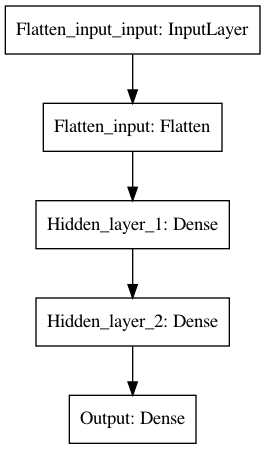

In [16]:
plot_model(model)

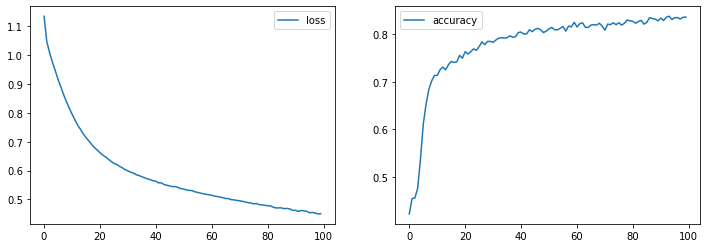

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.legend()
pass

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_loss, test_acc

6/6 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.78 - 0s 2ms/step - loss: 0.5752 - accuracy: 0.8111


(0.575153112411499, 0.8111110925674438)

The accuracy is about 80%. For a simple model with limited training set, this performance is not bad.

## Try to improve classification performance by hyperparameter tunning

We try to tunning the number of units in first hidden layer and the learning rate.

In [19]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(100, 100), name="Flatten_input"))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation = tf.nn.sigmoid, name="Hidden_layer_1"))
    model.add(keras.layers.Dense(16, activation = tf.nn.sigmoid, name="Hidden_layer_2"))
    model.add(keras.layers.Dense(3, activation = tf.nn.softmax, name="Output"))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = keras.optimizers.SGD(learning_rate = hp_learning_rate),
                loss = 'sparse_categorical_crossentropy', 
                metrics = ['accuracy'])

    return model

In [20]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='kt',
    project_name = 'kt_project')

INFO:tensorflow:Reloading Oracle from existing project kt/kt_project/oracle.json
INFO:tensorflow:Reloading Tuner from kt/kt_project/tuner0.json


In [21]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [22]:
retunning = False

if retunning:
    
    if os.path.exists('kt'):
        shutil.rmtree('kt')

    if os.path.exists('kt_project'):
        shutil.rmtree('kt_project')
    
tuner.search(X_train, y_train, epochs = 10, 
             validation_data = (X_test, y_test),
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [23]:
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.get('units'), best_hps.get('learning_rate')

(256, 0.01)

In [24]:
best_hist = best_model.fit(X_train, y_train,epochs=100, verbose=0)

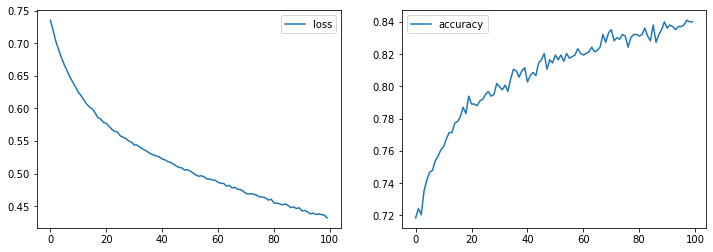

In [25]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(best_hist.history[measure], label=measure)
    ax.legend()
pass

In [26]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
test_loss, test_acc

6/6 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.75 - 0s 2ms/step - loss: 0.5678 - accuracy: 0.8167


(0.5677723288536072, 0.8166666626930237)

Seems no obvious improvement, which is sad. Maybe we need to try tunning other parameters, or just add more training data.

## Explain how our model classify insects

In [27]:
explainer = shap.GradientExplainer(best_model, X_train)

In [31]:
sv = explainer.shap_values(X_test[:10])

In [29]:
model.predict(X_test[:10]), y_test[:10]

(array([[0.04111223, 0.38144788, 0.57743984],
        [0.01283908, 0.13159503, 0.8555659 ],
        [0.6701151 , 0.28406647, 0.04581848],
        [0.02699221, 0.90831107, 0.06469667],
        [0.05692604, 0.77929944, 0.16377448],
        [0.03640981, 0.08732451, 0.8762657 ],
        [0.9205949 , 0.06933252, 0.01007263],
        [0.01420745, 0.0982885 , 0.887504  ],
        [0.9605511 , 0.03331361, 0.00613525],
        [0.01886279, 0.10616471, 0.87497246]], dtype=float32),
 array([2, 0, 0, 1, 1, 2, 0, 2, 0, 2]))

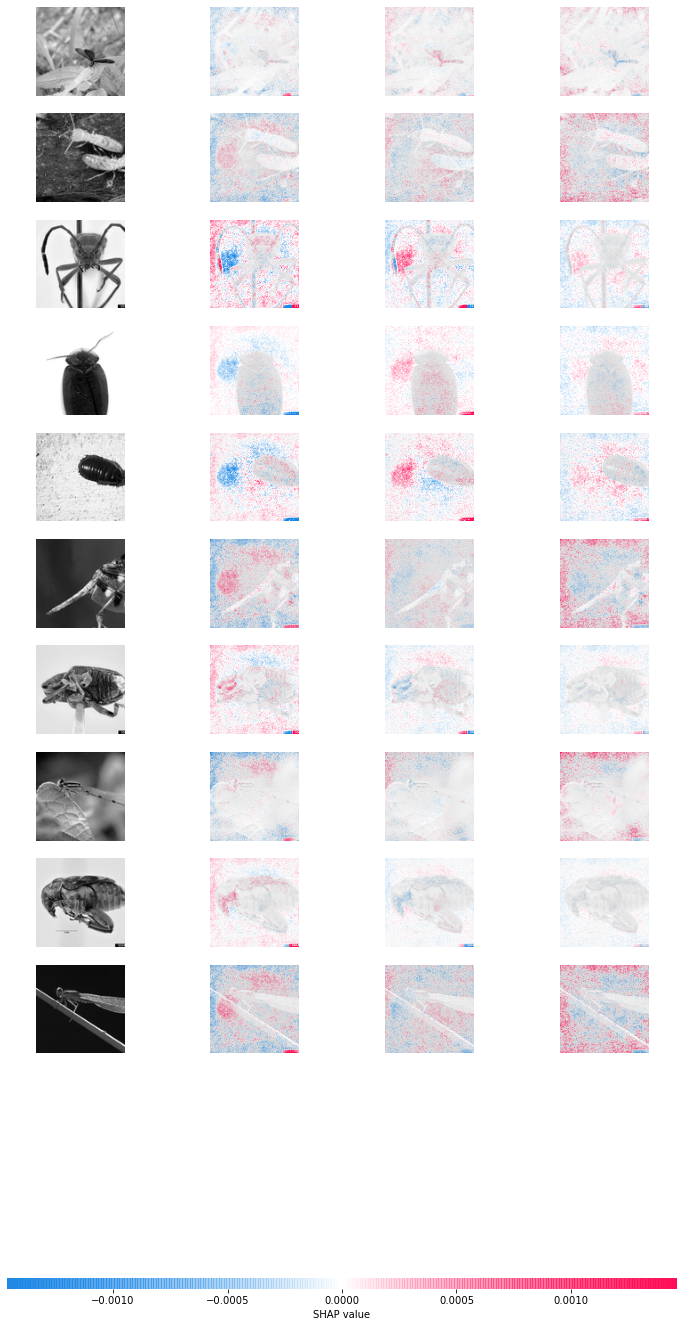

In [30]:
shap.image_plot([sv[i] for i in range(3)], X_test[:10])

When I first look into the images of three different types of insects, I am a little worry about if the model could do better than random guess, since some of the images are too ambiguous! Some of them are just heads, some of them are just tails, some of them are a bunch of insects, and some of them the insect is too small to see.

So when I found test accuracy turned out to be about 80%, I am a little surprised. I guess the model probably even performs better then me (I am really not an insect expert).

By looking at the SHAP plot, I found that the model's classifying logic is somehow weird. It seem that the model classify the insect mainly depends on the background gray level. A solid evidence is the second images, the true label is "dragonflies", but it was classified as "beetles". But it is clear that the second images is not dragonflies since they don't have wings, which for me should be an obvious features for dragonfly. Why this misclassification happened? We noticed that the background of second image is dark, while for most dragonflies images, the background color is dark, leading the model to think "oh, this dark-background images should be 'dragonflies'". The SHAP value of second image also shows that the dark background give evidence for "dragonflies".

I am not pretty sure how the model tell between beetles and cockroach. The SHAP value doesn't give me any clue. One guess is that the background for beetles is more pure compare to cockroach, which make some sense, since cockroach are more likely to live in dirty and messy envrionment(probably?)

Though the model's classifying logic seems don't make much sense for me, the model still sucessfully classify 80% of the test images. The model looks at the image as a whole and it pay attention to more macroscopic feature e.g. the background, while I focus more on local feature e.g. the if the insect has wing.

## Reference

1. https://developer.ibm.com/articles/image-recognition-challenge-with-tensorflow-and-keras-pt1/
2. https://www.tensorflow.org/tutorials/keras/keras_tuner